In [ ]:
import dask_gateway

cluster = dask_gateway.GatewayCluster()
client = cluster.get_client()
cluster.scale(40)
print(cluster.dashboard_link)

https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.733eaf4d997240b5aadfbdca4c9763b2/status


In [ ]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle

from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import fsspec

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12,8

import io
import os
%matplotlib inline
import matplotlib.pyplot as plt

# data management
import xarray as xr
import numpy as np
import pandas as pd

# Azure Connectivity
import getpass
import azure.storage.blob
from azure.storage.blob import BlobClient

# utilities
import time
import urllib.parse

# !pip install geopy 
from  geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="my-test-app")

In [4]:
################################
# Utils
################################

def get_xy_meshgrid(arr_tmax3d:np.ndarray) -> np.ndarray:
    """create grid for all x,y coordinate pairs [0,1],[0,2],..[283,583]"""
    
    shape_yx = arr_tmax3d.shape[1:] # np.shape order -> zyx
    arr_y = np.arange(shape_yx[0])
    arr_x = np.arange(shape_yx[1])
    ac = np.array(np.meshgrid(arr_x, arr_y)).T.reshape(-1, 2)
    
    return ac

def print_stats(arr:np.ndarray) -> None:
    size = round(arr_tmax3d.nbytes/1e9,2)
    shp = arr_tmax3d.shape
    print(f"""processing.. year={year}, shape z,y,x={shp}, in-memory={size} GB""")

In [40]:
ds = xr.open_mfdataset('./BCSD/*.nc', concat_dim="time", combine="nested")
ds

# is on Dask, a file reading bug comes up. Below is a work around; kinda.
# fp = '/home/jovyan/Koray/BCSD/tasmax_day_BCSD_historical_r1i1p1_inmcm4_1950.nc'
# ds = xr.open_dataset(fp)
# ds.sel(time='1950')['tasmax'].sel(lat=lat, lon=lon, method="nearest").values

<xarray.Dataset>
Dimensions:  (time: 10950, lat: 720, lon: 1440)
Coordinates:
  * time     (time) object 1950-01-01 12:00:00 ... 1979-12-31 12:00:00
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
Data variables:
    tasmax   (time, lat, lon) float32 dask.array<chunksize=(365, 720, 1440), meta=np.ndarray>
Attributes: (12/34)
    parent_experiment:              pre-industrial control
    parent_experiment_id:           piControl
    parent_experiment_rip:          r1i1p1
    Conventions:                    CF-1.4
    institution:                    NASA Earth Exchange, NASA Ames Research C...
    institute_id:                   NASA-Ames
    ...                             ...
    project_id:                     NEXGDDP
    table_id:                       Table day (12 November 2010)
    source:                         BCSD 2014
    creation_date:                  2015-01-07T20:32:02Z
    forcing:                        N/A
    product:                        output

In [38]:
# Ravi's avg 
ds_avg = xr.open_dataset("./Avg_temp_max_CMIP5__30_yrs__1950_to_1979.nc")

In [9]:
################################
# NEW algorithm that uses Ravi's Avg Temps
################################

# input: 1D tmax data
# output: same-size 1D flags where heat event == True
    
def flag_heat_events(arr_tmax1d: np.array, arr_tavg1d:np.array) -> np.array:
    """Feed 1 calendar year of data at a time."""
    
    # enrich
    df = pd.DataFrame({'diff': arr_tmax1d - arr_tavg1d})
    df['hot'] = df['diff'] > TEMP_DIFF_THRESHOLD 
    df['label'] = df['hot'].diff().ne(False).cumsum()
    df = df.reset_index().reset_index()

    # filter
    df['isSummer'] = (121 < df.index) & (df.index < 273) # May1-Sep1 
    dff = df[df['isSummer'] & df['hot']].dropna(subset=['diff']) 
    
    # groupby
    dfg = dff.groupby('label').agg({
        'index':[np.min,np.max,len],
        'diff':np.max
    })
    dfg.columns = ['i1','i2','count','peak_diff']
    dfg = dfg[dfg['count'] >= PERSISTED_FOR_MIN]
    dfg = dfg.drop('count', axis=1)
    dfg = dfg.reset_index(drop=True)

    # explode flags to a 365-length array
    arr = np.empty(len(df), dtype=np.float64)
    arr[:] = np.nan
    for _, (i, j, peak_diff) in dfg.iterrows():
        arr[int(i):int(j)+1] = peak_diff
        
    return arr


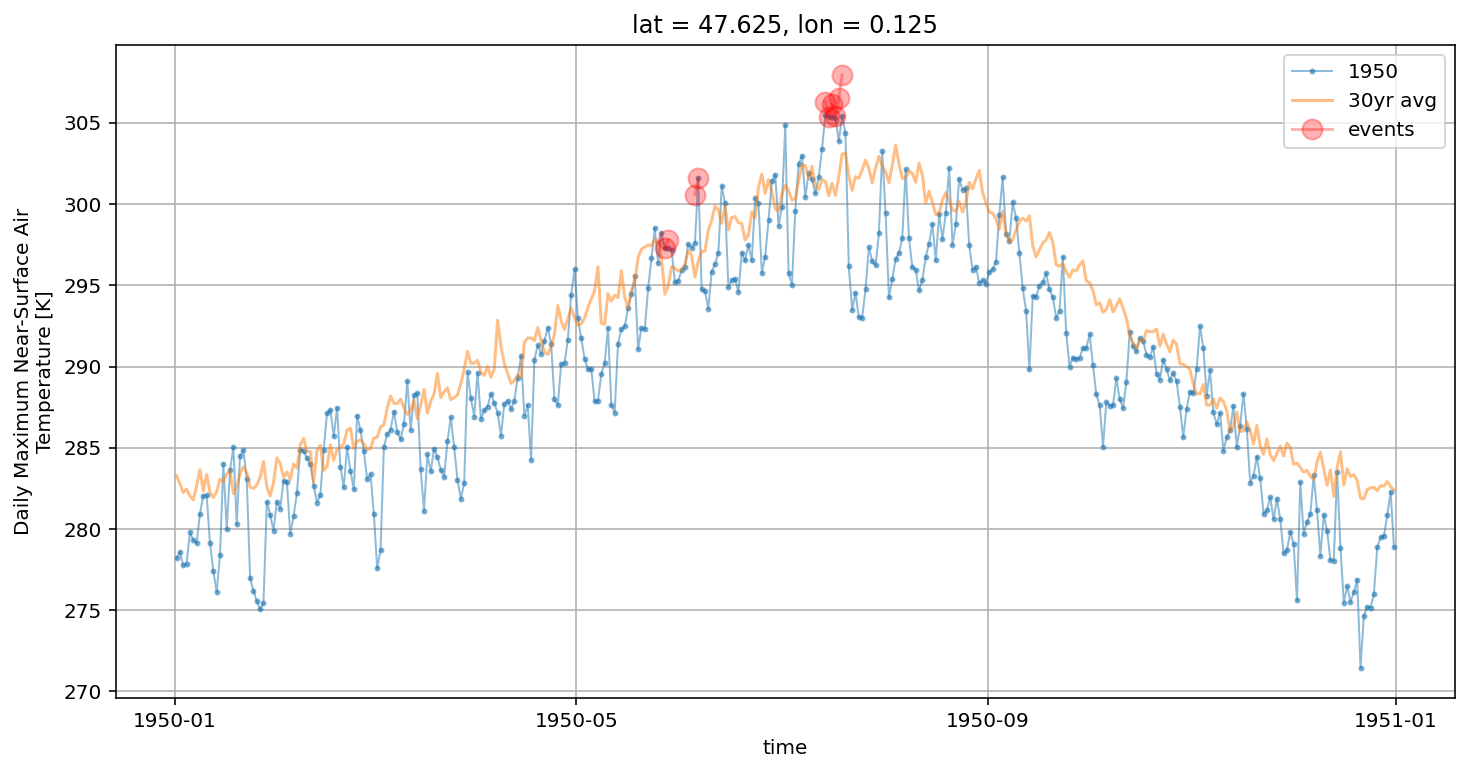

In [39]:
# ################################
# # Demonstarte the new algorithm makes sense
# ################################

# algorithm coefs:
TEMP_DIFF_THRESHOLD = 2 # Celcius (or K)
PERSISTED_FOR_MIN = 2 # days

loc = geolocator.geocode("Seattle,USA")
lat, lon = loc.latitude, loc.longitude
year = '1950'

ds_tasmax = ds.sel(time=year)['tasmax'].sel(lat=lat, lon=lon, method="nearest")

ds_tasmax.plot(label=year, marker='o', markersize=2, linewidth=1, alpha=.5, figsize=(12,6))

ax = plt.gca()
timestamps = ds.sel(time=year)['time'].values
arr_tavg1d = ds_avg['tasmaxavg'].sel(lat=lat, lon=lon, method="nearest").values

ax.plot(timestamps, arr_tavg1d, label="30yr avg", alpha=.5)

arr_heat1d = flag_heat_events(ds_tasmax.values, arr_tavg1d)

ax.plot(timestamps, arr_tavg1d+arr_heat1d, 
        label="events", marker='o', markersize=10, alpha=.3, color='r')

ax.legend()
ax.grid()

In [ ]:
%%time
print('started..')
import time

arr_tavg3d = ds_avg['tasmaxavg'].values # 365 fixed lenght

years = np.unique(ds['time'].dt.year).astype(str)

for year in years:

    t1 = time.time()

    # temp data
    arr_tmax3d = ds.sel(time=year)['tasmax'].values

    # empty array to populate
    arr_heat3d = np.empty(arr_tmax3d.shape, dtype=np.float64)
    arr_heat3d[:] = np.nan

    # loop
    meshgrid = get_xy_meshgrid(arr_tmax3d)
    for i, j in meshgrid:
        
        arr_tmax1d = arr_tmax3d[:,j,i]

        if np.isnan(arr_tmax1d).all():
            arr_heat1d = np.empty(arr_tmax1d.shape, dtype=np.float64)
            arr_heat1d[:] = np.nan
        else:
            arr_tavg1d = arr_tavg3d[:,j,i]
            arr_heat1d = flag_heat_events(arr_tmax1d, arr_tavg1d)

        arr_heat3d[:,j,i] = arr_heat1d  

    np.save(f'./events_2K_2days/arr_heat3d_{year}.npy', arr_heat3d)
    print(f'{round((time.time() - t1)/60, 2)}min')

started..
